In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import higher
import pickle

In [2]:
a = torch.ones(4,2)
b = torch.zeros(4)
b[a[:,1]>b] = a[:,1]

In [14]:
class TM(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.lin = torch.nn.Linear(1,1)

class MTM(TM):
    def __init__(self,):
        super().__init__()
    def reset(self, ):
        super().__init__()
    

In [18]:
a = MTM()
b = torch.nn.ModuleList([a])
b[0].lin.weight

Parameter containing:
tensor([[-0.4577]], requires_grad=True)

In [19]:
a.reset()
b[0].lin.weight

Parameter containing:
tensor([[0.4961]], requires_grad=True)

In [ ]:
def check_outpt(label, outpt, tol_neg, tol_pos):
    diff = label-outpt
    neg_acc = diff > tol_neg[None,None,:]
    pos_acc = diff < tol_pos[None,None,:]
    acc = neg_acc*pos_acc
    acc = acc.reshape(diff.size(0), -1)
    return torch.all(acc, dim=1)

In [ ]:
seq_len_global = 5

In [5]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken = 0, d_output = 0, d_model = 0, nhead = 0, d_hid = 0,
                 nlayers = 0, dropout = 0.2, model_setup = None):
        super().__init__()
        self.model_type = 'Transformer'
        if model_setup is not None:
            ntoken = model_setup['ntoken']
            d_output = model_setup['d_output']
            d_model = model_setup['d_model']
            nhead = model_setup['nhead']
            d_hid = model_setup['d_hid']
            nlayers = model_setup['nlayers']
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, d_output)

        #self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask = None) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

class TailorTransformer(TransformerModel):
    def __init__(self, ntoken=0, d_output=0, d_model=0, nhead=0, d_hid=0, nlayers=0, dropout=0.2, model_setup=None):
        self.super_init = False
        self.model_setup = model_setup
        
    def init_weights(self):
        self.super_init = False

    def forward(self, src: Tensor) -> Tensor:
        if not self.super_init:
            self.model_setup['ntoken'] = src.size(-1)
            self.model_setup['seq_len'] = src.size(1)
            super().__init__(model_setup = self.model_setup)
            self.result_encoder = nn.Linear(self.model_setup['d_output'] * self.model_setup['seq_len'], self.model_setup['d_result'])
            self.sm = torch.nn.Softmax(dim=-1)
            self.to(src.device)
            self.super_init = True


        #src: batch, seq, dim
        src = src.transpose(0,1)
        #src = seq, batch, dim
        #print(f'src shape: {src.shape}')
        pre_result = super().forward(src)
        pre_result = pre_result.transpose(0,1)

        #preresult = batch, seq, dim
        pre_result = pre_result.reshape(pre_result.size(0), -1)
        #print(f'preresult shape {pre_result.shape}')

        result = self.result_encoder(pre_result)
        result = self.sm(result)
        #print(f'result shape {result.shape}')

        return result


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def batchify(data: Tensor, bsz: int, device: str) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

def get_batch(source: Tensor, i: int, bptt : int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target



In [6]:
model_setup = {
    'use_layernorm':False,
    'd_output':50,
    'd_model' : 80,
    'nhead':10,
    'd_hid':80,
    'nlayers':4,
    'd_result':2,
}

In [37]:
a = TailorTransformer(model_setup= model_setup)
inpt = torch.rand((20,2,2), dtype=torch.float)
res = a.forward(inpt)
opt = torch.optim.SGD(a.parameters(), lr=1)
res = a.forward(inpt)
print(next(a.parameters())[0,:5])
res[:,0].sum().backward()
opt.step()
print(next(a.parameters())[0,:5])
res = a.forward(inpt)
print(next(a.parameters())[0,:5])
a.super_init = False
res = a.forward(inpt)
print(next(a.parameters())[0,:5])
opt = a.parameters()
opt.zero_grad()
res[:,0].sum().backward()
opt.step()
print(next(a.parameters())[0,:5])



tensor([-0.0514, -0.0593,  0.0549, -0.0218, -0.1211], grad_fn=<SliceBackward0>)
tensor([-0.0593, -0.0570,  0.0532, -0.0213, -0.1195], grad_fn=<SliceBackward0>)
tensor([-0.0593, -0.0570,  0.0532, -0.0213, -0.1195], grad_fn=<SliceBackward0>)
tensor([ 0.0900, -0.1344,  0.0753,  0.0182, -0.0639], grad_fn=<SliceBackward0>)


IndexError: too many indices for tensor of dimension 2

In [11]:
next(a.parameters())

Parameter containing:
tensor([[-0.0280,  0.1186,  0.0066,  ..., -0.0704, -0.0550, -0.0011],
        [-0.0501, -0.0521, -0.1017,  ..., -0.0336,  0.0658,  0.0691],
        [-0.1335,  0.0377,  0.0724,  ...,  0.0526, -0.0525, -0.0617],
        ...,
        [-0.0271,  0.1173, -0.0455,  ..., -0.0436, -0.0220,  0.1301],
        [ 0.1128, -0.0924,  0.1179,  ..., -0.1300, -0.1046, -0.0518],
        [-0.0160,  0.1092,  0.0656,  ..., -0.1224,  0.0933,  0.0672]],
       requires_grad=True)

In [13]:
next(a.parameters())

Parameter containing:
tensor([[ 0.0587, -0.1228,  0.0371,  ..., -0.0808,  0.0647,  0.1315],
        [-0.0957,  0.0538,  0.1005,  ..., -0.0812,  0.0178,  0.0790],
        [-0.0784, -0.0109,  0.0457,  ..., -0.0896, -0.0517,  0.1075],
        ...,
        [ 0.1049,  0.1286,  0.1265,  ...,  0.0932,  0.1235,  0.0524],
        [ 0.0314, -0.1337, -0.0456,  ...,  0.1090, -0.0299,  0.0790],
        [-0.1121,  0.1367, -0.1018,  ..., -0.0482,  0.0973, -0.0666]],
       requires_grad=True)

In [12]:
a.super_init = False
a.forward(inpt)

tensor([[0.5057, 0.4943],
        [0.4828, 0.5172]], grad_fn=<SoftmaxBackward0>)

In [1]:

def make_toy_data(num_examples, inpt_func, outpt_func):
    generator =  torch.rand(num_examples)
    inpt = inpt_func(generator)
    outpt = outpt_func(inpt)
    return inpt, outpt

def check_outpt(label, outpt, tol_neg, tol_pos, window = 0):
    if window > 0:
        tol_neg, tol_pos, inpt= make_sliding_tol(label=inpt, neg_tol=tol_neg, pos_tol=tol_pos, window=window)

    diff = label-outpt

    if window > 0:
        neg_acc = diff > tol_neg
        pos_acc = diff < tol_pos
    else:
        neg_acc = diff > tol_neg[None,None,:]
        pos_acc = diff < tol_pos[None,None,:]
    acc = neg_acc*pos_acc
    acc = acc.reshape(diff.size(0), -1)
    return torch.all(acc, dim=1)

def make_tol(std_dev, dim, add=1e-3, device = 'cpu'):
    tol_neg = - (torch.abs(torch.normal(mean=torch.zeros(dim), std=std_dev*torch.ones(dim))) + add).to(device)
    tol_pos = + (torch.abs(torch.normal(mean=torch.zeros(dim), std=std_dev*torch.ones(dim))) + add).to(device)
    return tol_neg, tol_pos

def make_func(dim_in,dim_out, seq_len):
    seq_add = torch.arange(0,1,1/seq_len)
    tri = torch.randint(low=0, high=dim_in, size=(dim_out, dim_in))
    signs = torch.randint(low=-1, high=2, size=(dim_in*dim_out,)).reshape(dim_out, dim_in)

    tri = tri.reshape(-1).repeat(seq_len).reshape(1,-1)
    seq_counter = torch.arange(0, seq_len).reshape(1,-1).repeat([dim_in*dim_out, 1]).T.reshape(1,-1)
    tri = torch.cat((seq_counter, tri), dim=0)
    def inner_fc(inpt):
        n = len(inpt)
        tri_n = tri.repeat([1, n])
        n_counter = torch.arange(0, n).reshape(1,-1).repeat([dim_in*dim_out*seq_len, 1]).T.reshape(1,-1)
        tri_n = torch.cat((n_counter, tri_n), dim=0)
        seq_inpt = inpt[:,None, :] + seq_add[None,:,None]
        result = seq_inpt[tuple(tri_n)]
        result = result.reshape(n,seq_len, dim_out, dim_in)
        result = result*signs[None,None,:,:]
        result[(signs==0)[None,None,:,:].repeat([result.size(0), result.size(1),1,1])]=1
        result = torch.prod(result, dim=-1)
        return result
    return inner_fc

def plot_fcts(inpt, neg_tol, pos_tol, window = 0):
    inpt_dim = len(inpt[0])
    if window==0:
        neg_inpt = (inpt + neg_tol[None,:]).numpy()
        pos_inpt = (inpt + pos_tol[None,:]).numpy()
    else:
        sliding_tol_pos, sliding_tol_neg, inpt= make_sliding_tol(label=inpt.unsqueeze(0), neg_tol=neg_tol, pos_tol=pos_tol, window=window)
        pos_inpt, neg_inpt = sliding_tol_pos.numpy(), sliding_tol_neg.numpy()
        inpt = inpt[0]

    np_inpt = inpt.numpy()
    print(f'input: {np_inpt.shape}')
    
    seq_len = len(inpt)
    num_graphs = int(np.ceil(np.sqrt(inpt_dim)))
    fig, ax = plt.subplots(num_graphs,num_graphs)
    fig.set_size_inches(9, 9)
    for sp in range(inpt_dim):
        idx = sp // num_graphs
        idy = sp  % num_graphs
        ax[idx,idy].clear()
        ax[idx,idy].plot(range(seq_len), np_inpt[:,sp], alpha=0.5, color='midnightblue')
        ax[idx,idy].plot(range(seq_len), neg_inpt[:,sp], alpha=0.5, color='orangered')
        ax[idx,idy].plot(range(seq_len), pos_inpt[:,sp], alpha=0.5, color='orangered')

def save(path, dict):
    if not os.path.exists(path):
        os.makedirs(path)

    for dk, data in dict.items():
        tdata = data
        torch.save(tdata, path + str(dk))

def make_toy_data(fct, n, dim_in, std = 0.1, data_path= None):
    inpt = torch.normal(mean=torch.zeros([n,1, dim_in]), std=std*torch.ones([n,1,dim_in]))
    print(inpt.max())
    print(inpt.min())
    label = fct(inpt[:,0])
    tl = label.transpose(0,2)
    tl = tl.reshape([tl.size(0),-1])
    mean_label = tl.mean(dim=1)
    label = label - mean_label
    tl = label.transpose(0,2)
    tl = tl.reshape([tl.size(0),-1])
    tmax = tl[:10].max(dim=1)[0]
    tmin = tl[:10].min(dim=1)[0]
    rel_corr = tmax - tmin
    label = label % 1

    data_sets = ['train', 'val', 'test']
    if data_path is not None:
        for i, set in enumerate(data_sets):
            path =  data_path + set + '/'
            start = i * int(len(inpt)/len(data_sets))
            end = (i+1) * int(len(inpt)/len(data_sets))
            print(start)
            print(end)
            save(path=path, dict={'inpt':5*inpt[start:end], 'label':label[start:end]})
    return inpt, label

def make_sliding_tol_dim(label, window = 9, pos = True):
    batch_size = label.size(0)
    batch_counter = torch.arange(batch_size)
    counter = torch.arange(label.size(-1) - window) + int(window/2)
    window_counter = torch.arange(window) - int(window/2)
    s_ind = counter.repeat([batch_size,window,1]).transpose(-1,-2)
    f_ind = (counter[:,None] + window_counter[None,:]).repeat([batch_size, 1,1])
    batch_ind = batch_counter.reshape(-1,1,1).repeat([1,f_ind.size(-2), f_ind.size(-1)])
    ind = tuple((batch_ind, f_ind, s_ind))
    label_repeated = label.unsqueeze(-1).repeat([1,1,label.size(-1)])
    label_ind = label_repeated[ind]
    result = label_ind.max(dim=-1)[0], label_ind.min(dim=-1)[0]
    return result

def make_sliding_tol(label, neg_tol, pos_tol, window=9):
    tols_pos, tols_neg = [], []
    for dim in range(label.size(-1)):
        tol_pos, tol_neg = make_sliding_tol_dim(label=label[:,:,dim], window=window)
        tols_pos.append(tol_pos.unsqueeze(-1))
        tols_neg.append(tol_neg.unsqueeze(-1))
    sliding_tol_pos, sliding_tol_neg = torch.cat(tuple(tols_pos), dim=-1), torch.cat(tuple(tols_neg), dim=-1)
    neg_inpt = (sliding_tol_neg[0] + neg_tol[None,:])
    pos_inpt = (sliding_tol_pos[0] + pos_tol[None,:])
    inpt = label[:, int(window/2):-(int(window/2) + 1)]
    result = pos_inpt, neg_inpt, inpt
    return result

In [ ]:
a = 

In [ ]:
inner_fct = make_func(dim_in=4, dim_out=4, seq_len=seq_len_global)


In [ ]:
neg, pos = make_tol(std_dev=5e-1, dim=4, add=5e-2)
a= (neg, pos)
path_to_file = '/home/hendrik/Documents/master_project/LokalData/metaworld/test/toy_data/tol/'
from os import path, makedirs
#dir_path = path.dirname(path.realpath(__file__))
if not path.exists(path_to_file):
    makedirs(path_to_file)
with open(path_to_file + 'tol.pkl', 'wb') as f:
    pickle.dump(a, f)  



In [ ]:
with open(path_to_file + 'tol.pkl', 'rb') as f:
    b = pickle.load(f)

In [23]:
inpt, label = make_toy_data(inner_fct, n=30000, dim_in=4, std=0.1, data_path='/home/hendrik/Documents/master_project/LokalData/metaworld/small/')
outpt = torch.clone(label)
outpt[0,0,0] = 20
#print(check_outpt(label=inpt, outpt=outpt, tol_neg=neg, tol_pos=pos))
#make_func(2,3,torch.tensor([1,2]))

tensor(0.4384)
tensor(-0.4484)
0
10000
10000
20000
20000
30000


input: (5, 4)


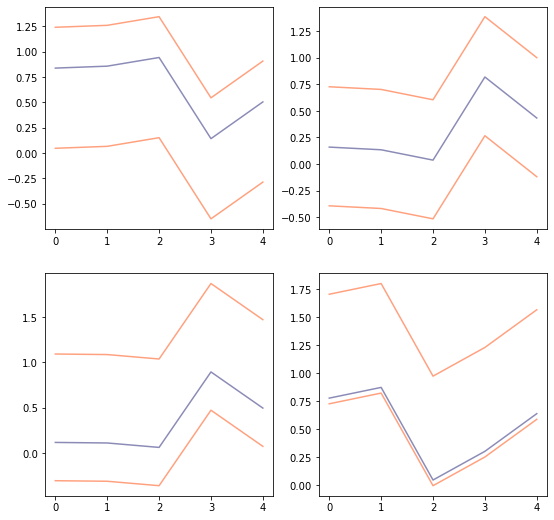

In [24]:
plot_fcts(inpt=label[0], neg_tol=neg, pos_tol=pos)

In [ ]:
neg = 0.1*-torch.ones(label.size(-1))
pos = 0.1*torch.ones(label.size(-1))
plot_fcts(label[0], neg, pos, window=9)

In [ ]:
neg, pos = make_tol(std_dev=5e-1, dim=4, add=1e-3)


In [ ]:
c1d = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=51, padding='same', padding_mode='reflect')
c1d.bias = torch.nn.Parameter(torch.zeros_like(c1d.bias))
c1d.weight = torch.nn.Parameter(1/51 * torch.ones_like(c1d.weight))

In [ ]:
label[:1,:,:1].shape

In [ ]:
convout1 = c1d(label[:1,:,:1].transpose(1,2)).detach()
convout2 = c1d(label[:1,:,1:2].transpose(1,2)).detach()
convout = torch.cat((convout1, convout2), dim=1)

In [ ]:
neg = label[:1,:,:2] - convout.transpose(1,2) - 0.1

In [ ]:
plot_fcts(inpt=label[2,4:-5], neg_tol=sliding_window[2], pos_tol=sliding_window[1])


In [ ]:
t1 = torch.arange(10)

In [ ]:
def make_sliding_tol_dim(label, window = 9, pos = True):
    batch_size = label.size(0)
    batch_counter = torch.arange(batch_size)
    counter = torch.arange(label.size(-1) - window) + int(window/2)
    window_counter = torch.arange(window) - int(window/2)
    s_ind = counter.repeat([batch_size,window,1]).transpose(-1,-2)
    f_ind = (counter[:,None] + window_counter[None,:]).repeat([batch_size, 1,1])
    batch_ind = batch_counter.reshape(-1,1,1).repeat([1,f_ind.size(-2), f_ind.size(-1)])
    ind = tuple((batch_ind, f_ind, s_ind))
    label_repeated = label.unsqueeze(-1).repeat([1,1,label.size(-1)])
    label_ind = label_repeated[ind]
    result = label_ind.max(dim=-1)[0], label_ind.min(dim=-1)[0]
    return result

def make_sliding_tol(label, neg_tol, pos_tol, window=9):
    tols_pos, tols_neg = [], []
    for dim in range(label.size(-1)):
        tol_pos, tol_neg = make_sliding_tol_dim(label=label[:,:,dim], window=window)
        tols_pos.append(tol_pos.unsqueeze(-1))
        tols_neg.append(tol_neg.unsqueeze(-1))
    sliding_tol_pos, sliding_tol_neg = torch.cat(tuple(tols_pos), dim=-1), torch.cat(tuple(tols_neg), dim=-1)
    neg_inpt = (sliding_tol_neg[0] + neg_tol[None,:])
    pos_inpt = (sliding_tol_pos[0] + pos_tol[None,:])
    inpt = label[:, int(window/2):-(int(window/2) + 1)]
    result = pos_inpt, neg_inpt, inpt
    return result

In [ ]:
sliding_window, a = make_sliding_tol(label=label[:10])
print(sliding_window.shape)

In [ ]:
tol0 = make_sliding_tol(label=label[:,:,0])[0]
tol1 = make_sliding_tol(label=label[:,:,1])[0]


In [ ]:
tol = torch.cat((tol0.unsqueeze(-1), tol1.unsqueeze(-1)), dim=-1)

In [ ]:
tol.shape

In [ ]:
counter = torch.arange(8) + 1
ccounter = torch.arange(3) - 1
s_ind = counter[:,None] + ccounter[None,:]
f_ind = counter.repeat([3,1]).transpose(0,1) - 1
ind = tuple((f_ind, s_ind))

In [ ]:
ind

In [ ]:
tr = t1.repeat([10,1])

In [ ]:
tr.shape

In [ ]:
tr.reshape(10,2,10)

In [ ]:
result = tr[ind]

In [ ]:
result

In [ ]:
label.shape

In [ ]:
neg.shape

In [ ]:
from torch.utils.data import DataLoader

class TorchDatasetMW(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data):
      self.data = data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        return self.data[index]

In [ ]:
data = torch.arange(10)
dataset = TorchDatasetMW(data)

In [ ]:
len(dataset)

In [ ]:
random_indices = torch.randperm(10)[:5]
trainset_1 = torch.utils.data.Subset(dataset, random_indices)

In [ ]:
loader = DataLoader(trainset_1)
for a in loader:
    print(a)

In [ ]:
a = torch.arange(5)

In [ ]:
a[random_indices]